In [1]:
import sys
sys.path.append("..")
# Reproducing https://www.nature.com/articles/s41566-020-0658-1
pw = (5,5)
a    =  0.850         # um
r    =  0.265 / a     # nat
h    =  0.100 / a     # nat
wl0  =  0.923 / a     # nat
esin = 2.02**2
from khepri import Crystal, Drawing
cl = Crystal(pw, lattice="hexagonal")
d = Drawing((128,128), esin, cl.lattice)
d.disc((0, 0), r, 1)

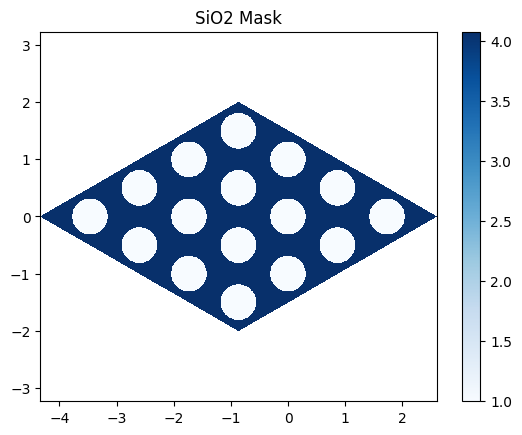

In [2]:
C = d.canvas()
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
a1, a2 = cl.lattice
for (i, j) in product(range(-2,2), range(-2, 2)):
    im = ax.pcolormesh(i*a1[0]+j*a2[0] + d.X, i*a1[1]+j*a2[1] +d.Y, C, cmap="Blues")
ax.axis("equal")
ax.set_title("SiO2 Mask")
plt.colorbar(im)

In [9]:
from tqdm import tqdm
from khepri.tools import block2dense

M, N = 128, 128
cl.add_layer_pixmap("A", d.canvas(), h)

c = 299792458 # m/s
fmax, fmin = 390e12 / (c/a*1e6), 300e12 / (c / a*1e6)
print(fmin, fmax)
fs = np.linspace(fmin, fmax, M)
ks = 2 * np.pi * np.linspace(-0.2, 0.2, N)
X, Y = np.meshgrid(fs, ks, indexing="ij")
RTs = list()
for f, kx in tqdm(list(product(fs, ks))):
    cl.set_source(1/f, 1, 1, kp=(kx, 0))
    cl.set_device(["A"])
    cl.solve()
    R, T = cl.poynting_flux_end()
    Stot = block2dense(cl.Stot)
    D = np.linalg.det(Stot)
    RTs.append((R,T, D))
RTs = np.array(RTs)

0.8505884427552877 1.105764975581874


100%|██████████| 16384/16384 [04:26<00:00, 61.57it/s]


(128, 128, 3)
0.923


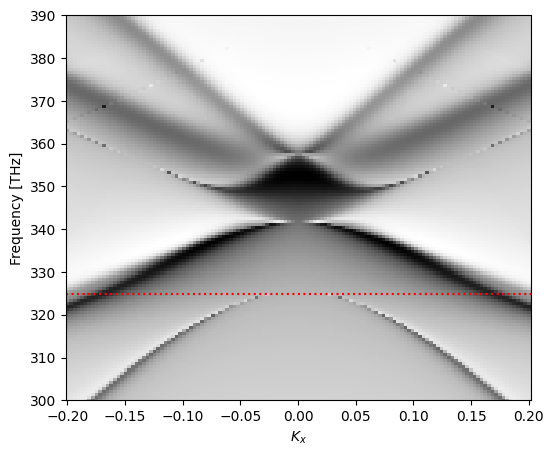

In [10]:
RTs = RTs.reshape(M,N,3)
print(RTs.shape)
fig, (ax1) = plt.subplots(1,1, figsize=(6,5))
#fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
fsdisp = fs * c / (a * 1e-6) / 1e12 # THz
ksdisp = ks
Xd, Yd = np.meshgrid(fsdisp, ksdisp/2/np.pi, indexing="ij")
ax1.pcolormesh(Yd, Xd, RTs[...,0].real, cmap="Greys", shading="nearest", vmin=0, vmax=1)
ax1.set_xlabel("$K_x$")
ax1.set_ylabel("Frequency [THz]")
m = 0.51
#fbic = 0.491
#ax1.plot(ks, fbic-ks**2/m/2, 'r:')  
ax1.axhline(c / 923e-9 * 1e-12, color="r", ls=":")
ax1.set_ylim(np.min(fsdisp), np.max(fsdisp))
print(wl0*a)
#ax2.pcolormesh(Y, X, np.gradient(np.log(RTs[...,2]).imag, axis=0)/2/np.pi, cmap="Greys", shading="nearest")

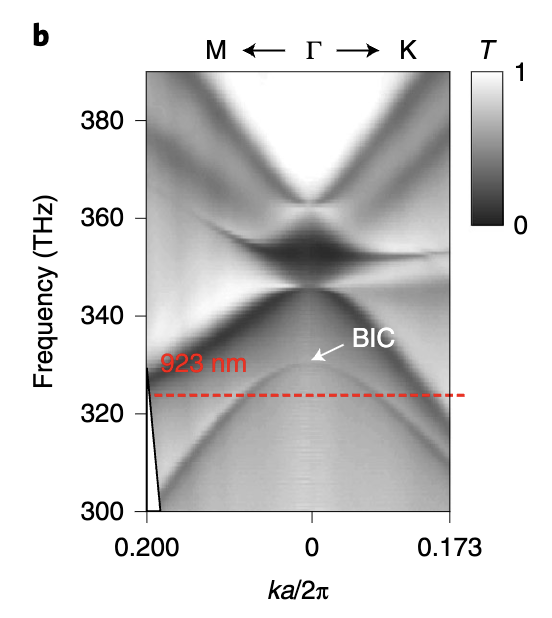